# Trainning Isolation Forest on specific anomaly rates
* Dataset       : KDDCUP99 100%
* Subset        : SA
* Total size    : 703066 
* Features      : ["duration", "service", "src_bytes", "dst_bytes"]
* Key attribute : logged_in = True

In [2]:
from imports import *

In [3]:
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
import time

# Configuration 1

In [6]:
df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
print(f"{df.columns}")
print(np.array(df.head(1)))

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target'],
      dtype='object')
[[0 'tcp' 'http' 'SF' 162 4528 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 2 0.0
  0.0 0.0 0.0 1.0 0.0 0.0 1 1 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 'normal.']]


In [7]:
scoring = {'AUC': 'roc_auc',
           'Precision': make_scorer(precision_score, pos_label=1), 
           'Recall': make_scorer(recall_score, pos_label=-1),
           'F1': make_scorer(f1_score, average='weighted')}

## Configuration 1
* anomaly_rate = 0.01
* 
* random_state = 1
* IF random_state = 1

In [8]:
r = 0.01
target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])
    
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=1)

gs_if_1 = GridSearchCV(IsolationForest(random_state = 1, n_jobs = -1),
                       param_grid={'contamination': np.arange(r, r*2, r/2), 'n_estimators': [100], 'max_samples': [0.25]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_1.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_1 = gs_if_1.cv_results_

frac = 0.1
df_sample_normal = df_sample.loc[df_sample["target"]=='normal.']
df_sample_attack = df_sample.loc[df_sample["target"]!='normal.']
dfsf_frac = df_sample_normal.sample(frac = frac, random_state = 2).append(df_sample_attack.sample(frac = frac, random_state = 2))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")  
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf_frac.drop(["target", 'binary_target'], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=2)

gs_svm_1 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                       param_grid={'nu': np.arange(r, r*2, r/2), 'kernel': ["rbf"], 'gamma': ["scale"]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_1.fit(x_train_sf, y_train_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
results_svm_1 = gs_svm_1.cv_results_

anomaly rate is 1.0% out of 982607 records (9827)
Time for IF fitting: 513.191
anomaly rate is 100.0% out of 98261 records
Time for SVM fitting: 33.797


In [ ]:
r = 0.02
target_anomaly_rate = r
rs = 2
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=rs))
df_sample = df_sample.sample(frac=1, random_state=rs)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])
    
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=rs)

gs_if_2 = GridSearchCV(IsolationForest(random_state = rs, n_jobs = -1),
                       param_grid={'contamination': np.arange(r, r*2, r/2), 'n_estimators': [100], 'max_samples': [0.25]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_1.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_1 = gs_if_1.cv_results_

frac = 0.1
df_sample_normal = df_sample.loc[df_sample["target"]=='normal.']
df_sample_attack = df_sample.loc[df_sample["target"]!='normal.']
dfsf_frac = df_sample_normal.sample(frac = frac, random_state = 2).append(df_sample_attack.sample(frac = frac, random_state = 2))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")  
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf_frac.drop(["target", 'binary_target'], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=2)

gs_svm_1 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                       param_grid={'nu': np.arange(r, r*2, r/2), 'kernel': ["rbf"], 'gamma': ["scale"]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_1.fit(x_train_sf, y_train_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
results_svm_1 = gs_svm_1.cv_results_

In [ ]:
r = 0.05
target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=3))
df_sample = df_sample.sample(frac=1, random_state=2)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])
    
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=2)

gs_if_1 = GridSearchCV(IsolationForest(random_state = 2, n_jobs = -1),
                       param_grid={'contamination': np.arange(r, r*2, r/2), 'n_estimators': [500], 'max_samples': [0.25]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_1.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_1 = gs_if_1.cv_results_

frac = 0.1
df_sample_normal = df_sample.loc[df_sample["target"]=='normal.']
df_sample_attack = df_sample.loc[df_sample["target"]!='normal.']
dfsf_frac = dfsf_normal.sample(frac = frac, random_state = 2).append(dfsf_attack.sample(frac = frac, random_state = 2))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")  
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf_frac.drop(["target", 'binary_target'], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=2)

gs_svm_1 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                       param_grid={'nu': np.arange(r, r*2, r/2), 'kernel': ["rbf"], 'gamma': ["scale"]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_1.fit(x_train_sf, y_train_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
results_svm_1 = gs_svm_1.cv_results_

In [ ]:
r = 0.01
target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])
    
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=1)

gs_if_1 = GridSearchCV(IsolationForest(random_state = 1, n_jobs = -1),
                       param_grid={'contamination': np.arange(r, r*2, r/2), 'n_estimators': [100], 'max_samples': [0.25]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_1.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_1 = gs_if_1.cv_results_

gs_svm_1 = GridSearchCV(OneClassSVM(kernel="rbf", gamma='scale'),
                       param_grid={'nu': np.arange(r, r*2, r/2), 'kernel': ["rbf"], 'gamma': ["scale"]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_svm_1.fit(x_train_sf, y_train_sf)
print("Time for SVM fitting: %.3f" % (time.time() - stime))
results_svm_1 = gs_svm_1.cv_results_

frac = 0.1
df_sample_normal = df_sample.loc[df_sample["target"]=='normal.']
df_sample_attack = df_sample.loc[df_sample["target"]!='normal.']
dfsf_frac = dfsf_normal.sample(frac = frac, random_state = 2).append(dfsf_attack.sample(frac = frac, random_state = 2))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")  
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf_frac.drop(["target", 'binary_target'], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=2)

stime = time.time()
gs_if_1.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_1 = gs_if_1.cv_results_



<ipython-input-112-1b835375f516>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


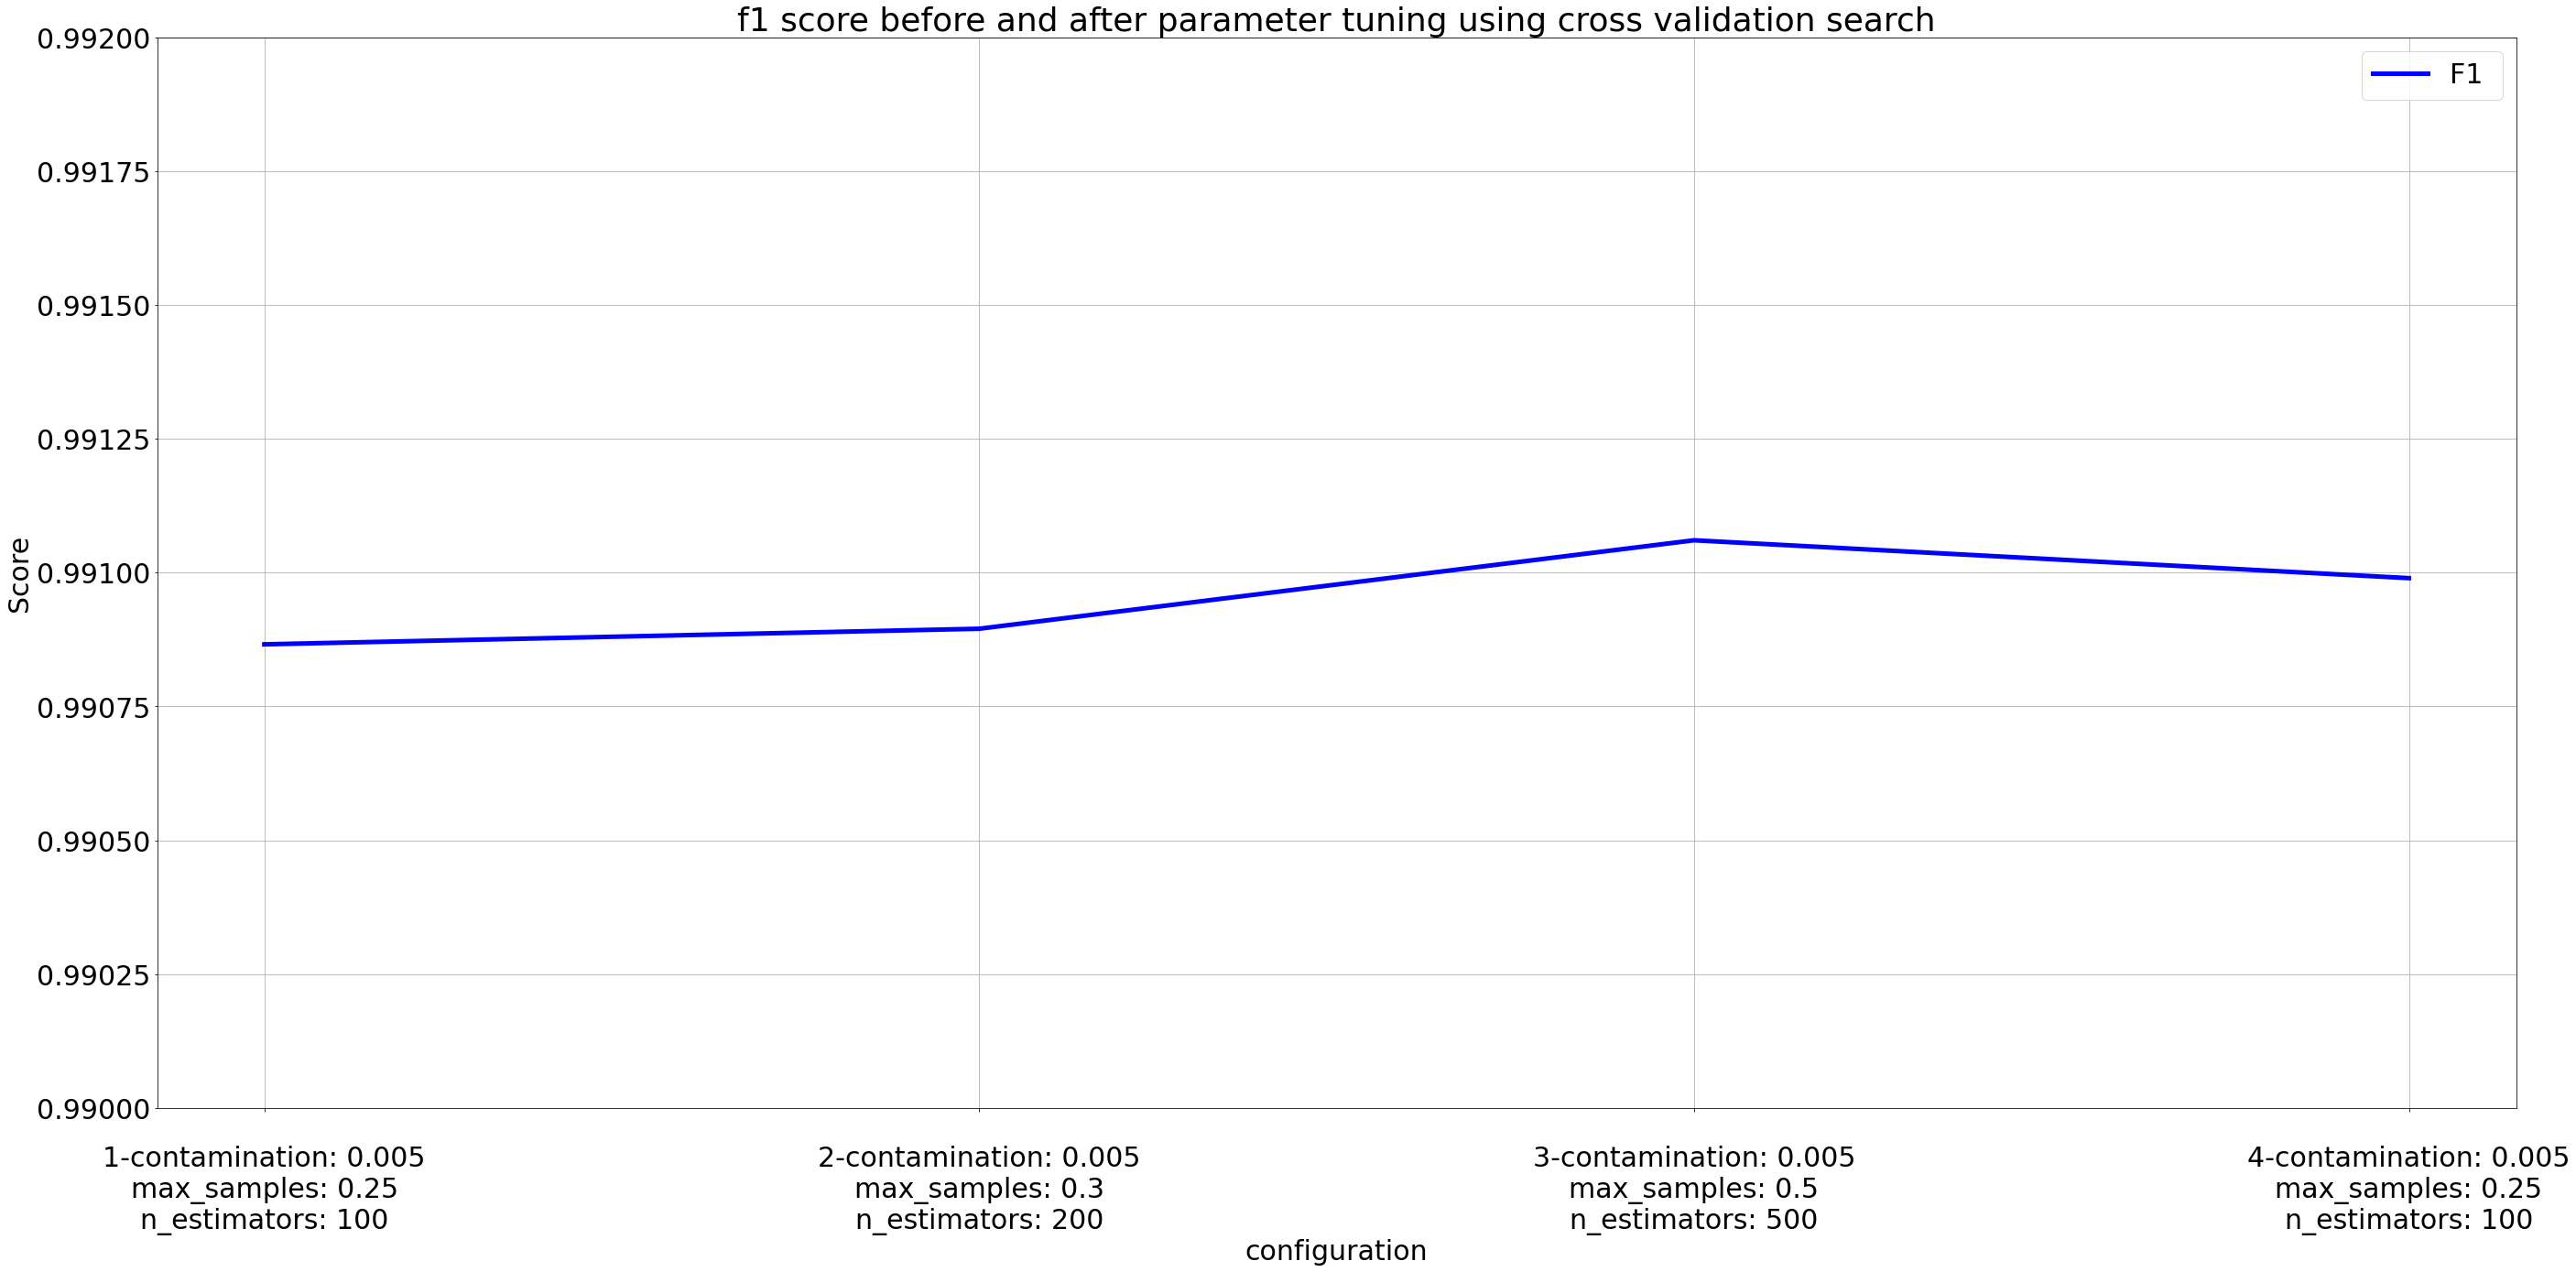

In [112]:
plt.figure(figsize=(40,20))
plt.title('F1 score for each dataset size')
plt.xlabel("Dataset size")
plt.ylabel("Score")
plt.rc('font', size=30)
ax = plt.axes()
ax.set_ylim(0.99, 0.992)
pad = 0.005

labels = np.array([0.1, 0.2, 0.5, 1.0])

colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'F1'

best_index = np.nonzero(results_if_1['rank_test_%s' % scorer] == 1)[0][0]
best_score_1 = results_if_1['mean_test_%s' % scorer][best_index]
best_param_1 = results_if_1['params'][best_index]

best_index = np.nonzero(results_if_2['rank_test_%s' % scorer] == 1)[0][0]
best_score_2 = results_if_2['mean_test_%s' % scorer][best_index]
best_param_2 = results_if_2['params'][best_index]

best_index = np.nonzero(results_if_3['rank_test_%s' % scorer] == 1)[0][0]
best_score_3 = results_if_3['mean_test_%s' % scorer][best_index]
best_param_3 = results_if_3['params'][best_index]

best_index = np.nonzero(results_if_4['rank_test_%s' % scorer] == 1)[0][0]
best_score_4 = results_if_4['mean_test_%s' % scorer][best_index]
best_param_4 = results_if_4['params'][best_index]

Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)

ax.plot(X_axis, Y_axis, '-', color=colors['2'],label="%s " % (scorer), linewidth=5)
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("IF_graph_dataset_size.png", dpi=100)

plt.show()

# Comparison against default values

In [20]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=1)
param = best_param_1
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 1).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sf, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 1).fit(x_train_sf).predict(x_test_sf)
print(f"---{f1_score(y_test_sf, y_pred)}")

tuned parameters: {'contamination': 0.005, 'max_samples': 0.25, 'n_estimators': 100}
Time for IF fitting: 23.011
---0.9954178136425095
---0.9615918309257809


In [21]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=2)
param = best_param_2
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 2).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sf, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 2).fit(x_train_sf).predict(x_test_sf)
print(f"---{f1_score(y_test_sf, y_pred)}")

tuned parameters: {'contamination': 0.005, 'max_samples': 0.3, 'n_estimators': 200}
Time for IF fitting: 46.105
---0.9952542140292294
---0.955213461022107


In [22]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=3)
param = best_param_3
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 3).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sf, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 3).fit(x_train_sf).predict(x_test_sf)
print(f"---{f1_score(y_test_sf, y_pred)}")

tuned parameters: {'contamination': 0.005, 'max_samples': 0.5, 'n_estimators': 500}
Time for IF fitting: 124.934
---0.9953171367636211
---0.9576507857113085


In [23]:
x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.25, random_state=4)
param = best_param_4
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 4).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sf, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 4).fit(x_train_sf).predict(x_test_sf)
print(f"---{f1_score(y_test_sf, y_pred)}")

tuned parameters: {'contamination': 0.005, 'max_samples': 0.25, 'n_estimators': 100}
Time for IF fitting: 23.037
---0.9952334249285871
---0.9571646010002174


No handles with labels found to put in legend.


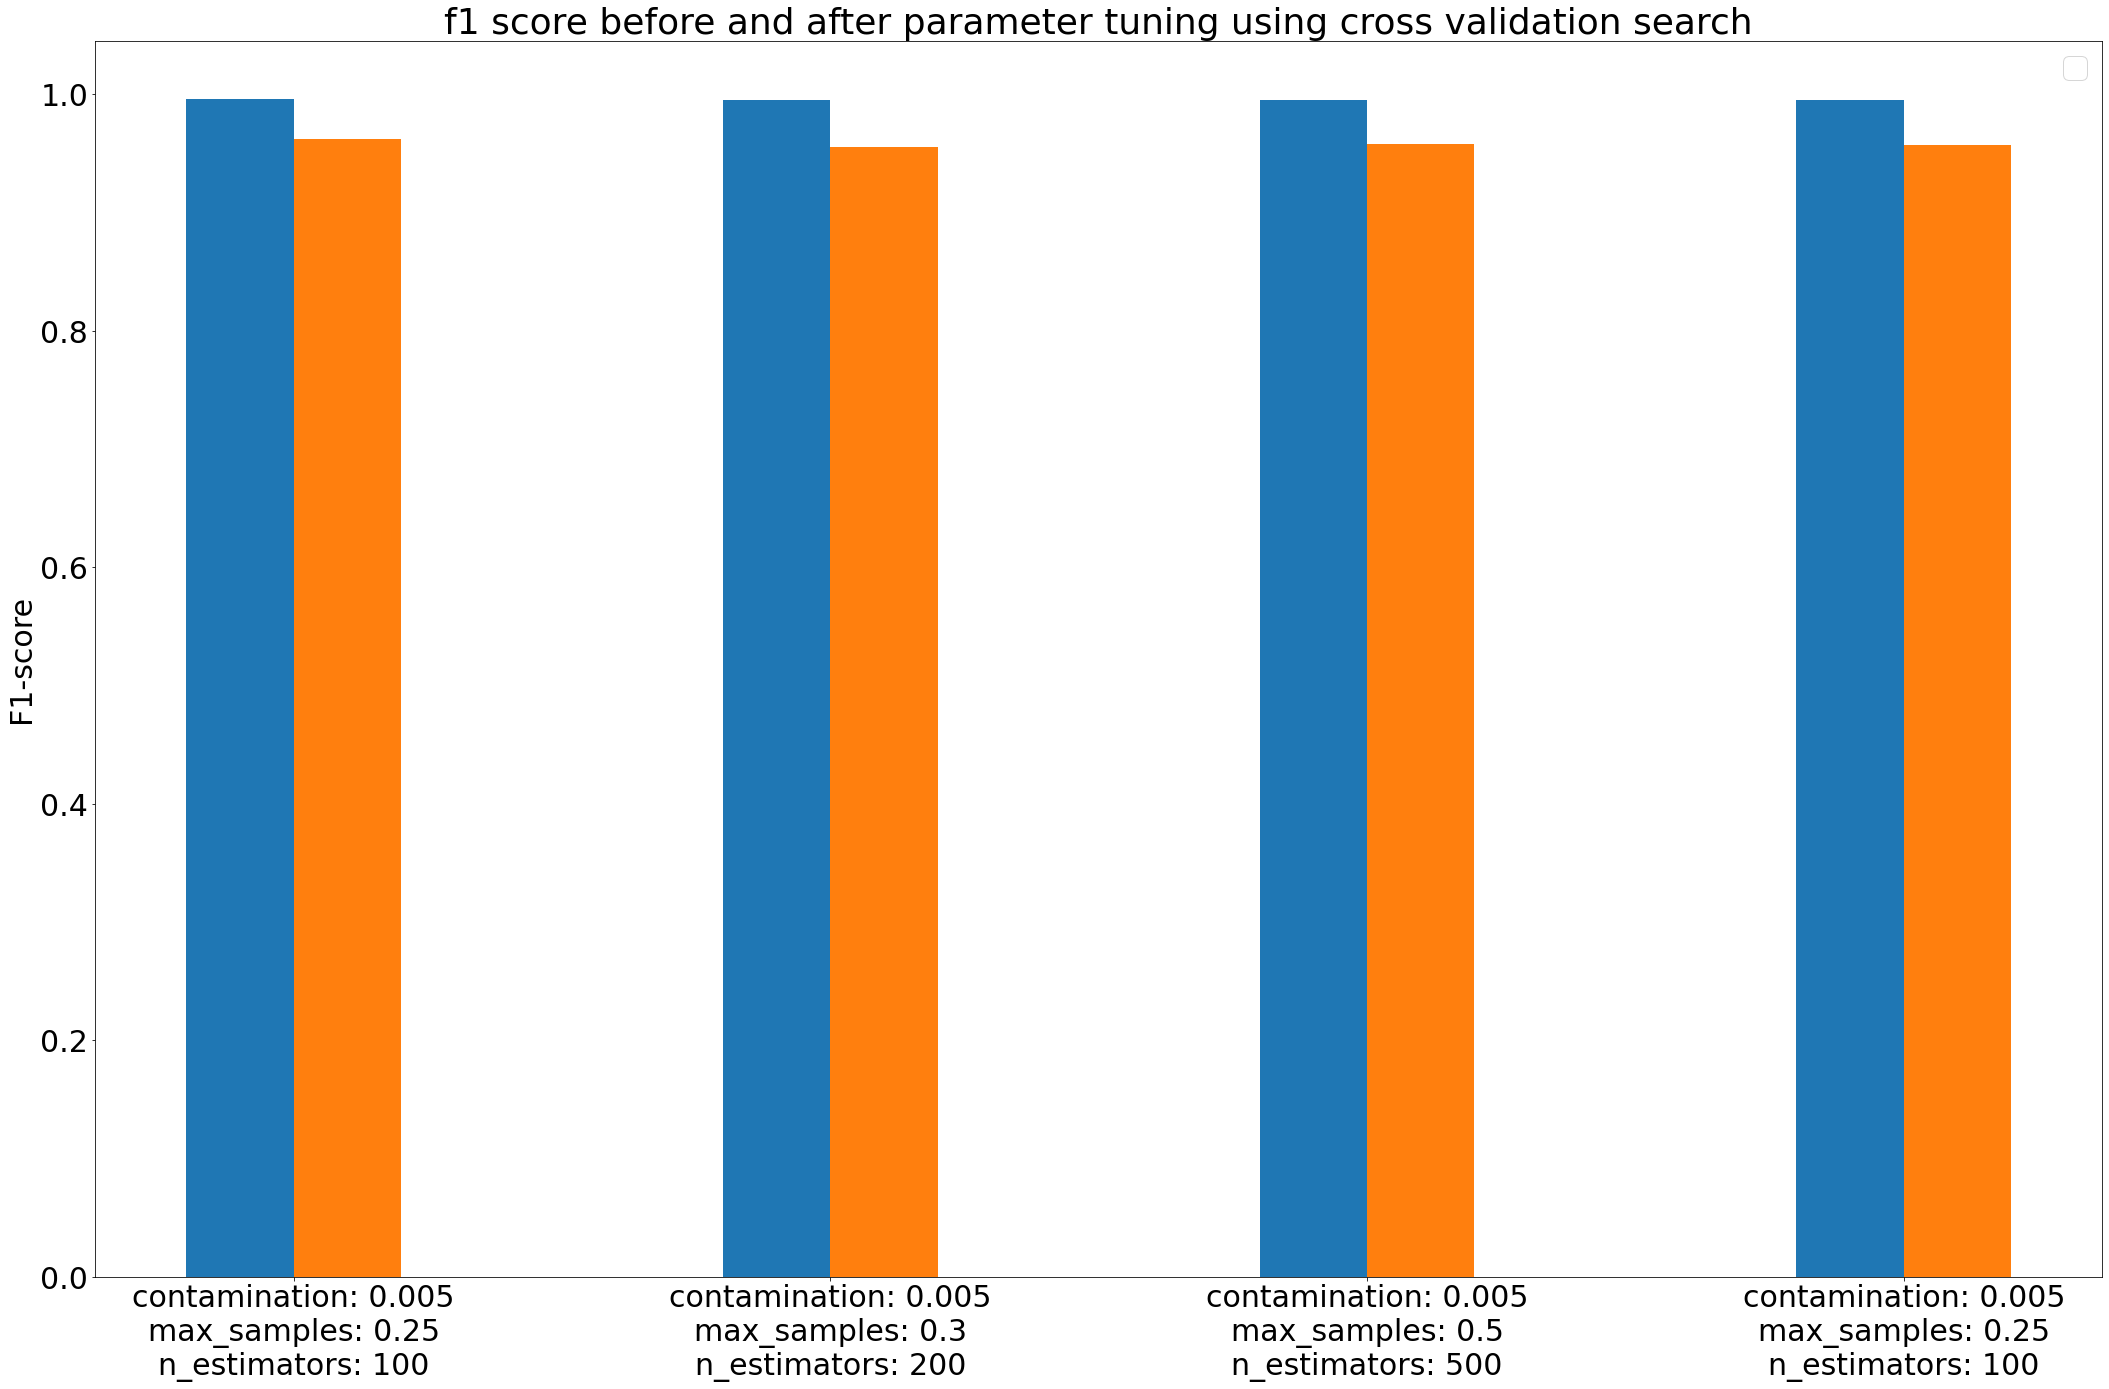

In [118]:
fig, ax = plt.subplots(figsize = (30,20))
plt.rc('font', size=30)

f1_tuned = [0.9954178136425095, 0.9952542140292294, 0.9953171367636211, 0.9952334249285871]
f1_default = [0.9615918309257809, 0.955213461022107, 0.9576507857113085, 0.9571646010002174]
width = 1
labels = [f"contamination: {best_param_1['contamination']}\nmax_samples: {best_param_1['max_samples']}\nn_estimators: {best_param_1['n_estimators']}", 
          f"contamination: {best_param_2['contamination']}\nmax_samples: {best_param_2['max_samples']}\nn_estimators: {best_param_2['n_estimators']}", 
          f"contamination: {best_param_3['contamination']}\nmax_samples: {best_param_3['max_samples']}\nn_estimators: {best_param_3['n_estimators']}", 
          f"contamination: {best_param_4['contamination']}\nmax_samples: {best_param_4['max_samples']}\nn_estimators: {best_param_4['n_estimators']}"]
ax.set_xticks([i*5 + width/2 for i in range(len(f1_tuned))])
ax.set_xticklabels(labels)
ax.set_ylabel('F1-score')

ax.legend(['f1 score tuned', 'f1 score not tuned'])
ax.set_title('f1 score before and after parameter tuning using cross validation search')

ax.bar([i*5 for i in range(len(f1_tuned))], f1_tuned, width=width)
ax.bar([i*5 + width for i in range(len(f1_tuned))], f1_default, width=width)
fig.tight_layout()
ax.legend()
plt.show()

# Archive

### Configuration 1

In [29]:
results_if_1

{'mean_fit_time': array([11.43813841, 11.22227422, 11.11450609, 11.08152453, 11.08858943,
        11.21968706, 11.24747125, 11.1452895 , 11.14281178, 11.13559874,
        11.13646754, 11.14192255, 11.12940152, 11.1571908 , 11.1468269 ]),
 'std_fit_time': array([0.4544924 , 0.01700449, 0.06269525, 0.02470291, 0.04067418,
        0.05597926, 0.14372142, 0.01191742, 0.01149813, 0.01743009,
        0.02367606, 0.0045874 , 0.01651623, 0.01127387, 0.02553649]),
 'mean_score_time': array([9.47395349, 9.55460723, 9.43976418, 9.36910995, 9.36207167,
        9.52912982, 9.37647041, 9.41717196, 9.41296236, 9.40189338,
        9.38822317, 9.42955105, 9.4253428 , 9.43857964, 9.4228793 ]),
 'std_score_time': array([0.0583327 , 0.01066837, 0.04265724, 0.01758521, 0.02521456,
        0.02297617, 0.01425201, 0.02473747, 0.02784792, 0.02313254,
        0.03197218, 0.0299291 , 0.01768193, 0.03774781, 0.02859176]),
 'param_contamination': masked_array(data=[0.005, 0.006, 0.007, 0.008, 0.009000000000000001

In [30]:
param = best_param_1
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 1).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(classification_report(y_test_sf, y_pred, target_names=["normal", "anomaly"]))

tuned parameters: {'contamination': 0.005, 'max_samples': 0.25, 'n_estimators': 100}
Time for IF fitting: 23.094
              precision    recall  f1-score   support

      normal       0.08      0.08      0.08       881
     anomaly       1.00      1.00      1.00    174886

    accuracy                           0.99    175767
   macro avg       0.54      0.54      0.54    175767
weighted avg       0.99      0.99      0.99    175767



### Configuration 2

In [31]:
results_if_2

{'mean_fit_time': array([22.2070516 , 22.17748292, 22.33598749, 22.2015295 , 22.21713972,
        22.29012402, 22.25194073, 22.18382494, 22.20013094, 22.09997853,
        22.0863963 , 22.15912819, 22.18315395, 22.20337264, 22.15917969]),
 'std_fit_time': array([0.06495758, 0.03438009, 0.06955071, 0.03271062, 0.06630697,
        0.02705332, 0.01557386, 0.00942742, 0.0294159 , 0.00741833,
        0.03056318, 0.0752527 , 0.05425509, 0.06122946, 0.0379481 ]),
 'mean_score_time': array([18.4906323 , 18.49480152, 18.61802991, 18.50694942, 18.53642352,
        18.68529359, 18.60554242, 18.58027625, 18.63385351, 18.51195725,
        18.49078679, 18.62252879, 18.67086585, 18.63004788, 18.63203414]),
 'std_score_time': array([0.06636289, 0.01893155, 0.08349894, 0.03970666, 0.03918805,
        0.00449531, 0.06652338, 0.04291261, 0.05295622, 0.03896536,
        0.03006142, 0.08365167, 0.10642803, 0.05325135, 0.09347739]),
 'param_contamination': masked_array(data=[0.005, 0.006, 0.007, 0.008, 0.009

In [34]:
param = best_param_2
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 2).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(classification_report(y_test_sf, y_pred, target_names=["normal", "anomaly"]))

tuned parameters: {'contamination': 0.005, 'max_samples': 0.3, 'n_estimators': 200}
Time for IF fitting: 46.211
              precision    recall  f1-score   support

      normal       0.07      0.08      0.07       881
     anomaly       1.00      1.00      1.00    174886

    accuracy                           0.99    175767
   macro avg       0.53      0.54      0.53    175767
weighted avg       0.99      0.99      0.99    175767



### Configuration 3

In [35]:
results_if_3

{'mean_fit_time': array([60.2691505 , 60.18612655, 60.09497897, 60.21448509, 60.15280374,
        60.14741556, 60.16783881, 59.99393773, 60.22161762, 60.27657151,
        60.00377862, 60.04556084, 60.14866471, 60.12109407, 60.19819665]),
 'std_fit_time': array([0.07117251, 0.27640652, 0.09963031, 0.17694485, 0.25635824,
        0.06834077, 0.21441804, 0.32115056, 0.13875736, 0.38379014,
        0.13979465, 0.20062165, 0.20840719, 0.24476304, 0.17611159]),
 'mean_score_time': array([48.68257356, 48.45259651, 48.38667305, 48.40991195, 48.46386679,
        48.40999293, 48.34790174, 48.37399785, 48.72398607, 48.45659288,
        48.37407136, 48.46043062, 48.50130637, 48.38544337, 48.55336642]),
 'std_score_time': array([0.08320808, 0.16007729, 0.09690013, 0.07550758, 0.27046498,
        0.0172126 , 0.04511386, 0.19481726, 0.22348437, 0.14525973,
        0.11009862, 0.13585012, 0.08230485, 0.11760031, 0.05494437]),
 'param_contamination': masked_array(data=[0.005, 0.006, 0.007, 0.008, 0.009

In [119]:
param = best_param_3
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 3).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(classification_report(y_test_sf, y_pred, target_names=["normal", "anomaly"]))

tuned parameters: {'contamination': 0.005, 'max_samples': 0.5, 'n_estimators': 500}
Time for IF fitting: 124.519
              precision    recall  f1-score   support

      normal       0.08      0.09      0.08       881
     anomaly       1.00      1.00      1.00    174886

    accuracy                           0.99    175767
   macro avg       0.54      0.54      0.54    175767
weighted avg       0.99      0.99      0.99    175767



### Configuration 4

In [121]:
results_if_4

{'mean_fit_time': array([10.99292699, 11.03155613, 10.97915173, 11.01194795, 11.01886026,
        11.02188055, 11.04015152, 11.03498054, 11.03127829, 11.00608603,
        10.99956282, 10.99225942, 11.02608164, 11.03847535, 11.04100005]),
 'std_fit_time': array([0.05260157, 0.03987962, 0.04878756, 0.04073996, 0.0463912 ,
        0.06011464, 0.02955394, 0.02395395, 0.0348998 , 0.04246364,
        0.03154973, 0.02327336, 0.04474236, 0.04110177, 0.02659435]),
 'mean_score_time': array([9.36325788, 9.37559358, 9.33260306, 9.36047514, 9.35570415,
        9.36059237, 9.38181869, 9.3673389 , 9.37059132, 9.34872659,
        9.34548585, 9.34253208, 9.37545315, 9.40001559, 9.38827507]),
 'std_score_time': array([0.04379658, 0.02528186, 0.02074409, 0.046115  , 0.01325273,
        0.0425162 , 0.02265928, 0.0230874 , 0.02503413, 0.02688898,
        0.03673303, 0.02947272, 0.03562132, 0.05902244, 0.03358403]),
 'param_contamination': masked_array(data=[0.005, 0.006, 0.007, 0.008, 0.009000000000000001

In [122]:
param = best_param_4
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 4).fit(x_train_sf).predict(x_test_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(classification_report(y_test_sf, y_pred, target_names=["normal", "anomaly"]))

tuned parameters: {'contamination': 0.005, 'max_samples': 0.25, 'n_estimators': 100}
Time for IF fitting: 22.818
              precision    recall  f1-score   support

      normal       0.08      0.08      0.08       881
     anomaly       1.00      1.00      1.00    174886

    accuracy                           0.99    175767
   macro avg       0.54      0.54      0.54    175767
weighted avg       0.99      0.99      0.99    175767



# Parameter tuning for Isolation Forest
* Dataset       : KDDCUP99 100%
* Subset        : SA
* Total size    :  
* Features      : 41
* Key attribute : 

In [123]:
r = 0.01
target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

anomaly rate is 1.0% out of 982607 records (9827)


In [124]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=1)
gs_if_sa_1 = GridSearchCV(IsolationForest(random_state = 1, n_jobs = -1),
                       param_grid={'contamination': np.arange(0.01, 0.02, 0.001), 'n_estimators': [100], 'max_samples': [0.25]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_sa_1.fit(x_train_sa, y_train_sa)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_sa_1 = gs_if_sa_1.cv_results_

Time for IF fitting: 1790.493


In [127]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=2)
gs_if_sa_2 = GridSearchCV(IsolationForest(random_state = 2, n_jobs = -1),
                       param_grid={'contamination': np.arange(0.01, 0.02, 0.001), 'n_estimators': [200], 'max_samples': [0.3]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_sa_2.fit(x_train_sa, y_train_sa)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_sa_2 = gs_if_sa_2.cv_results_

Time for IF fitting: 3801.667


In [128]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=3)
gs_if_sa_3 = GridSearchCV(IsolationForest(random_state = 3, n_jobs = -1),
                       param_grid={'contamination': np.arange(0.01, 0.02, 0.001), 'n_estimators': [500], 'max_samples': [0.5]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_sa_3.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_sa_3 = gs_if_sa_3.cv_results_

Time for IF fitting: 3384.219


In [132]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=4)
gs_if_sa_4 = GridSearchCV(IsolationForest(random_state = 4, n_jobs = -1),
                       param_grid={'contamination': np.arange(0.005, 0.02, 0.001), 'n_estimators': [1000], 'max_samples': [0.25]},
                       scoring=scoring, refit='F1', cv=3)
stime = time.time()
gs_if_sa_4.fit(x_train_sf, y_train_sf)
print("Time for IF fitting: %.3f" % (time.time() - stime))
results_if_sa_4 = gs_if_sa_4.cv_results_

Time for IF fitting: 9001.333


<ipython-input-134-799e8f1faaf0>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


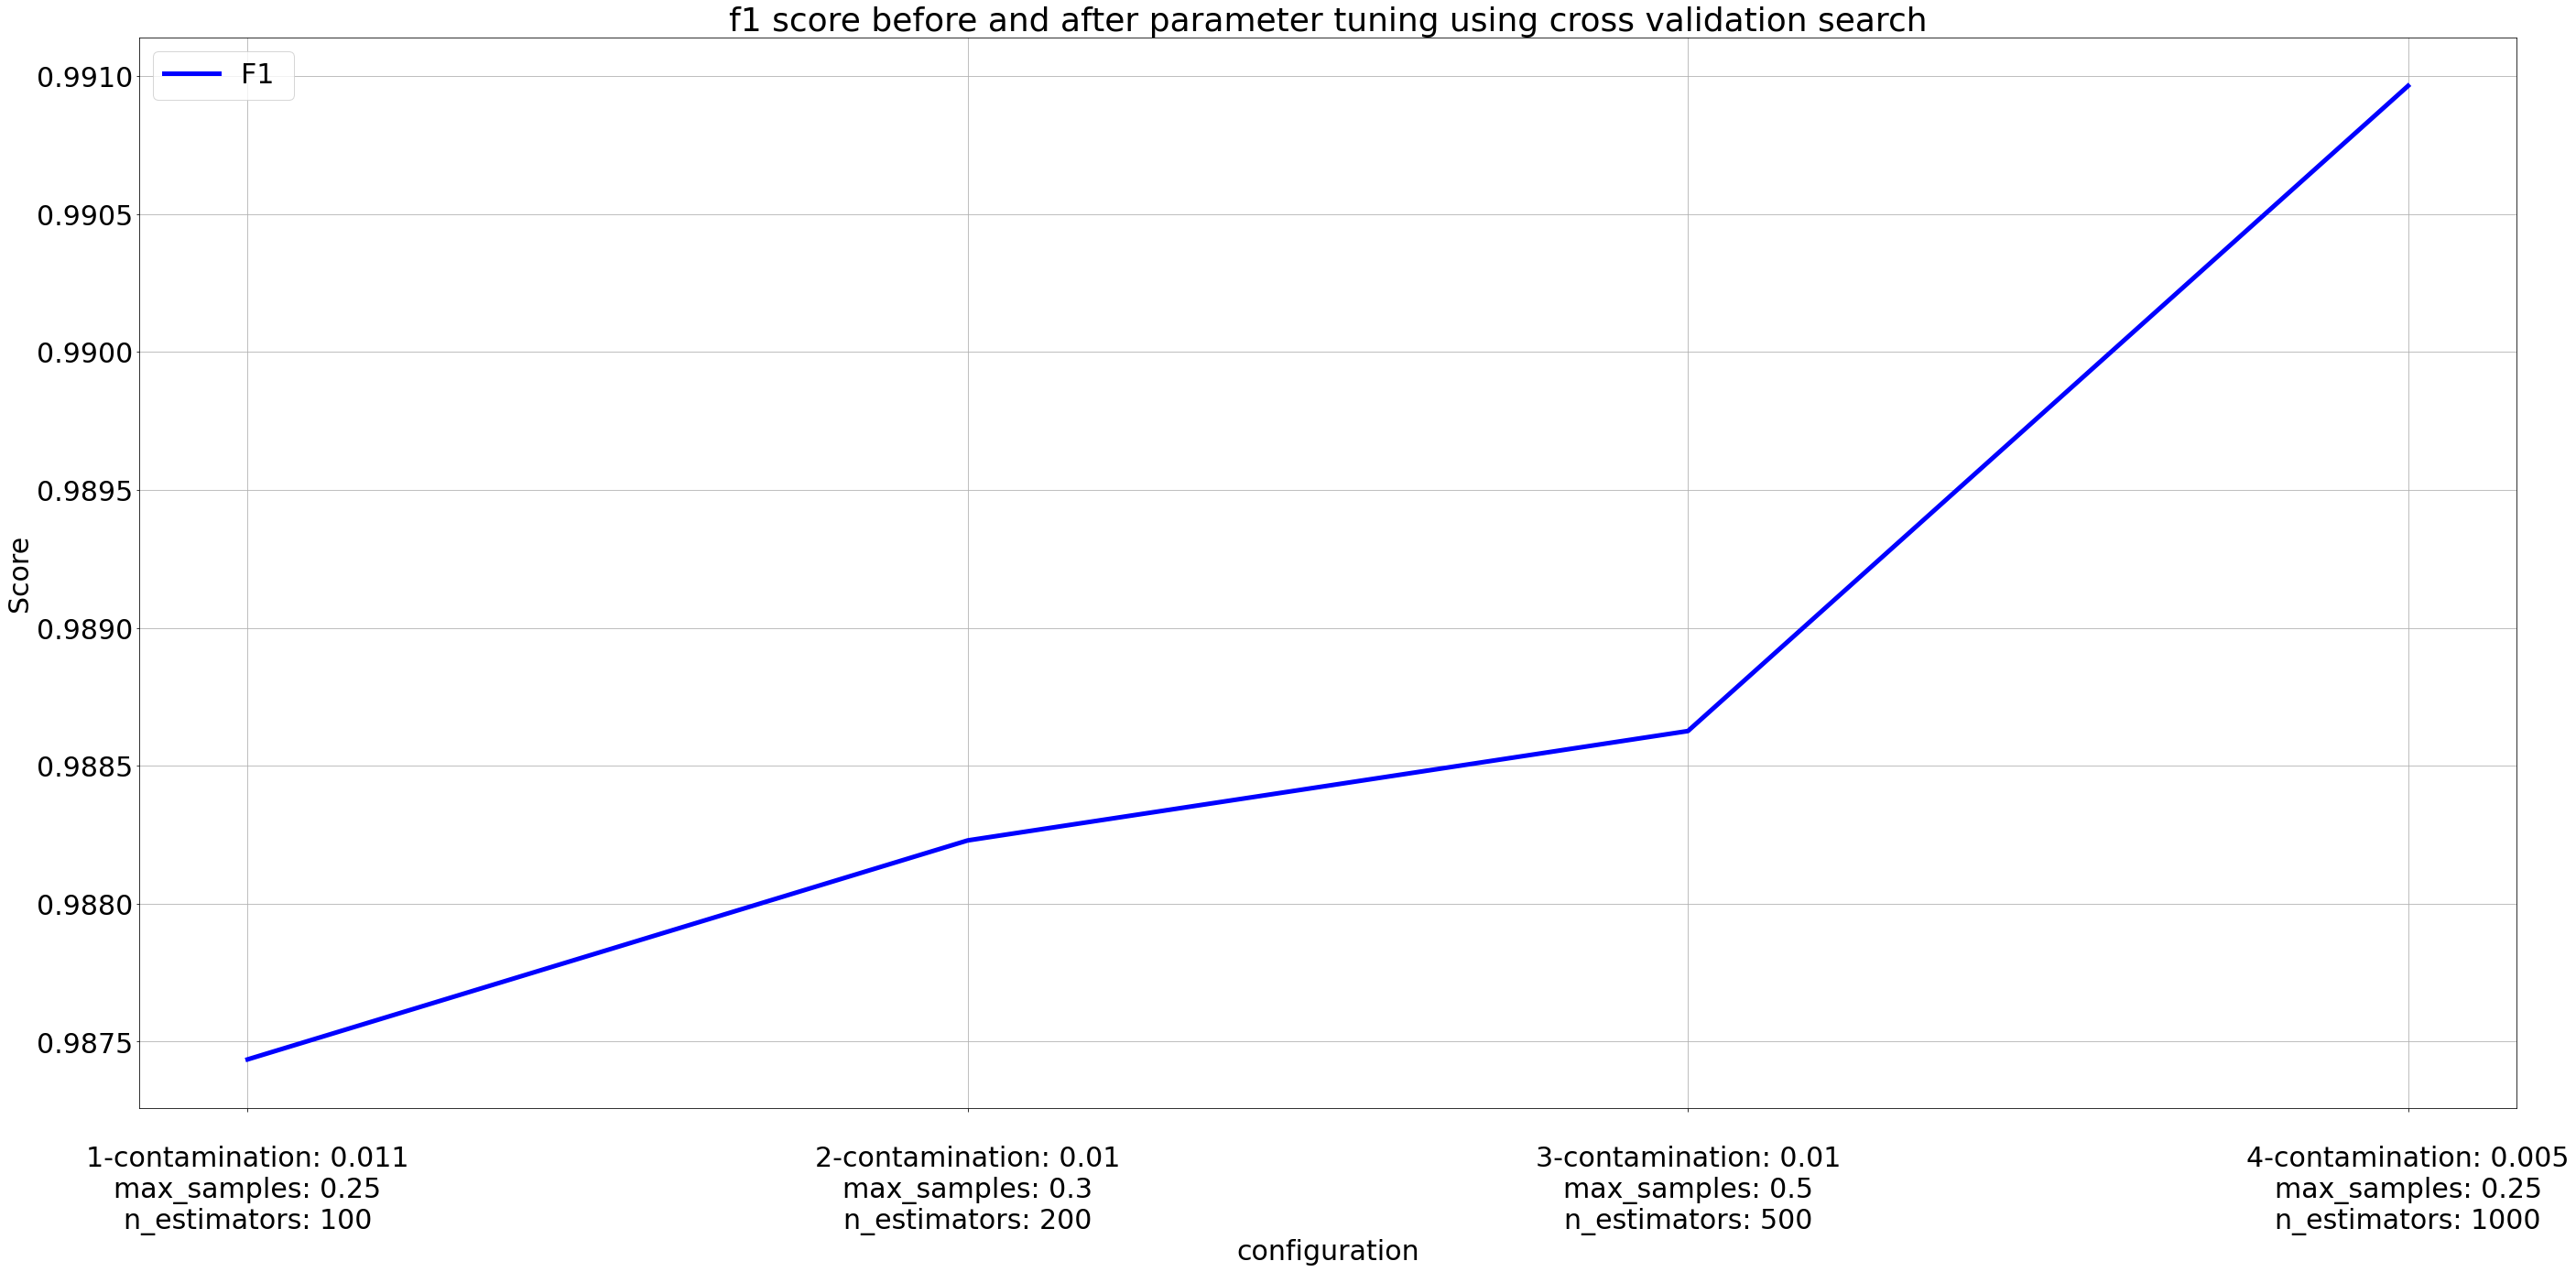

In [134]:
plt.figure(figsize=(40,20))
plt.title('f1 score before and after parameter tuning using cross validation search')
plt.xlabel("configuration")
plt.ylabel("Score")
plt.rc('font', size=30)
ax = plt.axes()
# ax.set_ylim(0.99, 0.992)
pad = 0.005

colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'F1'

best_index = np.nonzero(results_if_sa_1['rank_test_%s' % scorer] == 1)[0][0]
best_score_1 = results_if_sa_1['mean_test_%s' % scorer][best_index]
best_param_1 = results_if_sa_1['params'][best_index]

best_index = np.nonzero(results_if_sa_2['rank_test_%s' % scorer] == 1)[0][0]
best_score_2 = results_if_sa_2['mean_test_%s' % scorer][best_index]
best_param_2 = results_if_sa_2['params'][best_index]

best_index = np.nonzero(results_if_sa_3['rank_test_%s' % scorer] == 1)[0][0]
best_score_3 = results_if_sa_3['mean_test_%s' % scorer][best_index]
best_param_3 = results_if_sa_3['params'][best_index]

best_index = np.nonzero(results_if_sa_4['rank_test_%s' % scorer] == 1)[0][0]
best_score_4 = results_if_sa_4['mean_test_%s' % scorer][best_index]
best_param_4 = results_if_sa_4['params'][best_index]

labels = [f"\n1-contamination: {best_param_1['contamination']}\nmax_samples: {best_param_1['max_samples']}\nn_estimators: {best_param_1['n_estimators']}", 
          f"\n2-contamination: {best_param_2['contamination']}\nmax_samples: {best_param_2['max_samples']}\nn_estimators: {best_param_2['n_estimators']}", 
          f"\n3-contamination: {best_param_3['contamination']}\nmax_samples: {best_param_3['max_samples']}\nn_estimators: {best_param_3['n_estimators']}", 
          f"\n4-contamination: {best_param_4['contamination']}\nmax_samples: {best_param_4['max_samples']}\nn_estimators: {best_param_4['n_estimators']}"]

Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)

ax.plot(X_axis, Y_axis, '-', color=colors['2'],label="%s " % (scorer), linewidth=5)
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("IF_graph_sa.png", dpi=100)

plt.show()

# Comparison against default values

In [135]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=1)
param = best_param_1
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 1).fit(x_train_sa).predict(x_test_sa)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sa, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 1).fit(x_train_sa).predict(x_test_sa)
print(f"---{f1_score(y_test_sa, y_pred)}")

tuned parameters: {'contamination': 0.011, 'max_samples': 0.25, 'n_estimators': 100}
Time for IF fitting: 72.493
---0.9938100232381187
---0.9562713987832191


In [136]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=2)
param = best_param_2
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 2).fit(x_train_sa).predict(x_test_sa)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sa, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 2).fit(x_train_sa).predict(x_test_sa)
print(f"---{f1_score(y_test_sa, y_pred)}")

tuned parameters: {'contamination': 0.01, 'max_samples': 0.3, 'n_estimators': 200}
Time for IF fitting: 146.024
---0.9942422373020768
---0.9597852245622667


In [137]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=3)
param = best_param_3
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 3).fit(x_train_sa).predict(x_test_sa)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sa, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 3).fit(x_train_sa).predict(x_test_sa)
print(f"---{f1_score(y_test_sa, y_pred)}")

tuned parameters: {'contamination': 0.01, 'max_samples': 0.5, 'n_estimators': 500}
Time for IF fitting: 410.937
---0.9938514652089926
---0.9585052379616803


In [138]:
x_train_sa, x_test_sa, y_train_sa, y_test_sa = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=4)
param = best_param_4
print(f"tuned parameters: {param}")
stime = time.time()
y_pred = IsolationForest(contamination=param['contamination'], max_samples=param['max_samples'], n_estimators=param['n_estimators'], n_jobs = -1, random_state = 4).fit(x_train_sa).predict(x_test_sa)
print("Time for IF fitting: %.3f" % (time.time() - stime))
print(f"---{f1_score(y_test_sa, y_pred)}")
y_pred = IsolationForest(n_jobs = -1, random_state = 4).fit(x_train_sa).predict(x_test_sa)
print(f"---{f1_score(y_test_sa, y_pred)}")

tuned parameters: {'contamination': 0.005, 'max_samples': 0.25, 'n_estimators': 1000}
Time for IF fitting: 729.087
---0.9948938578646892
---0.9640969083271412


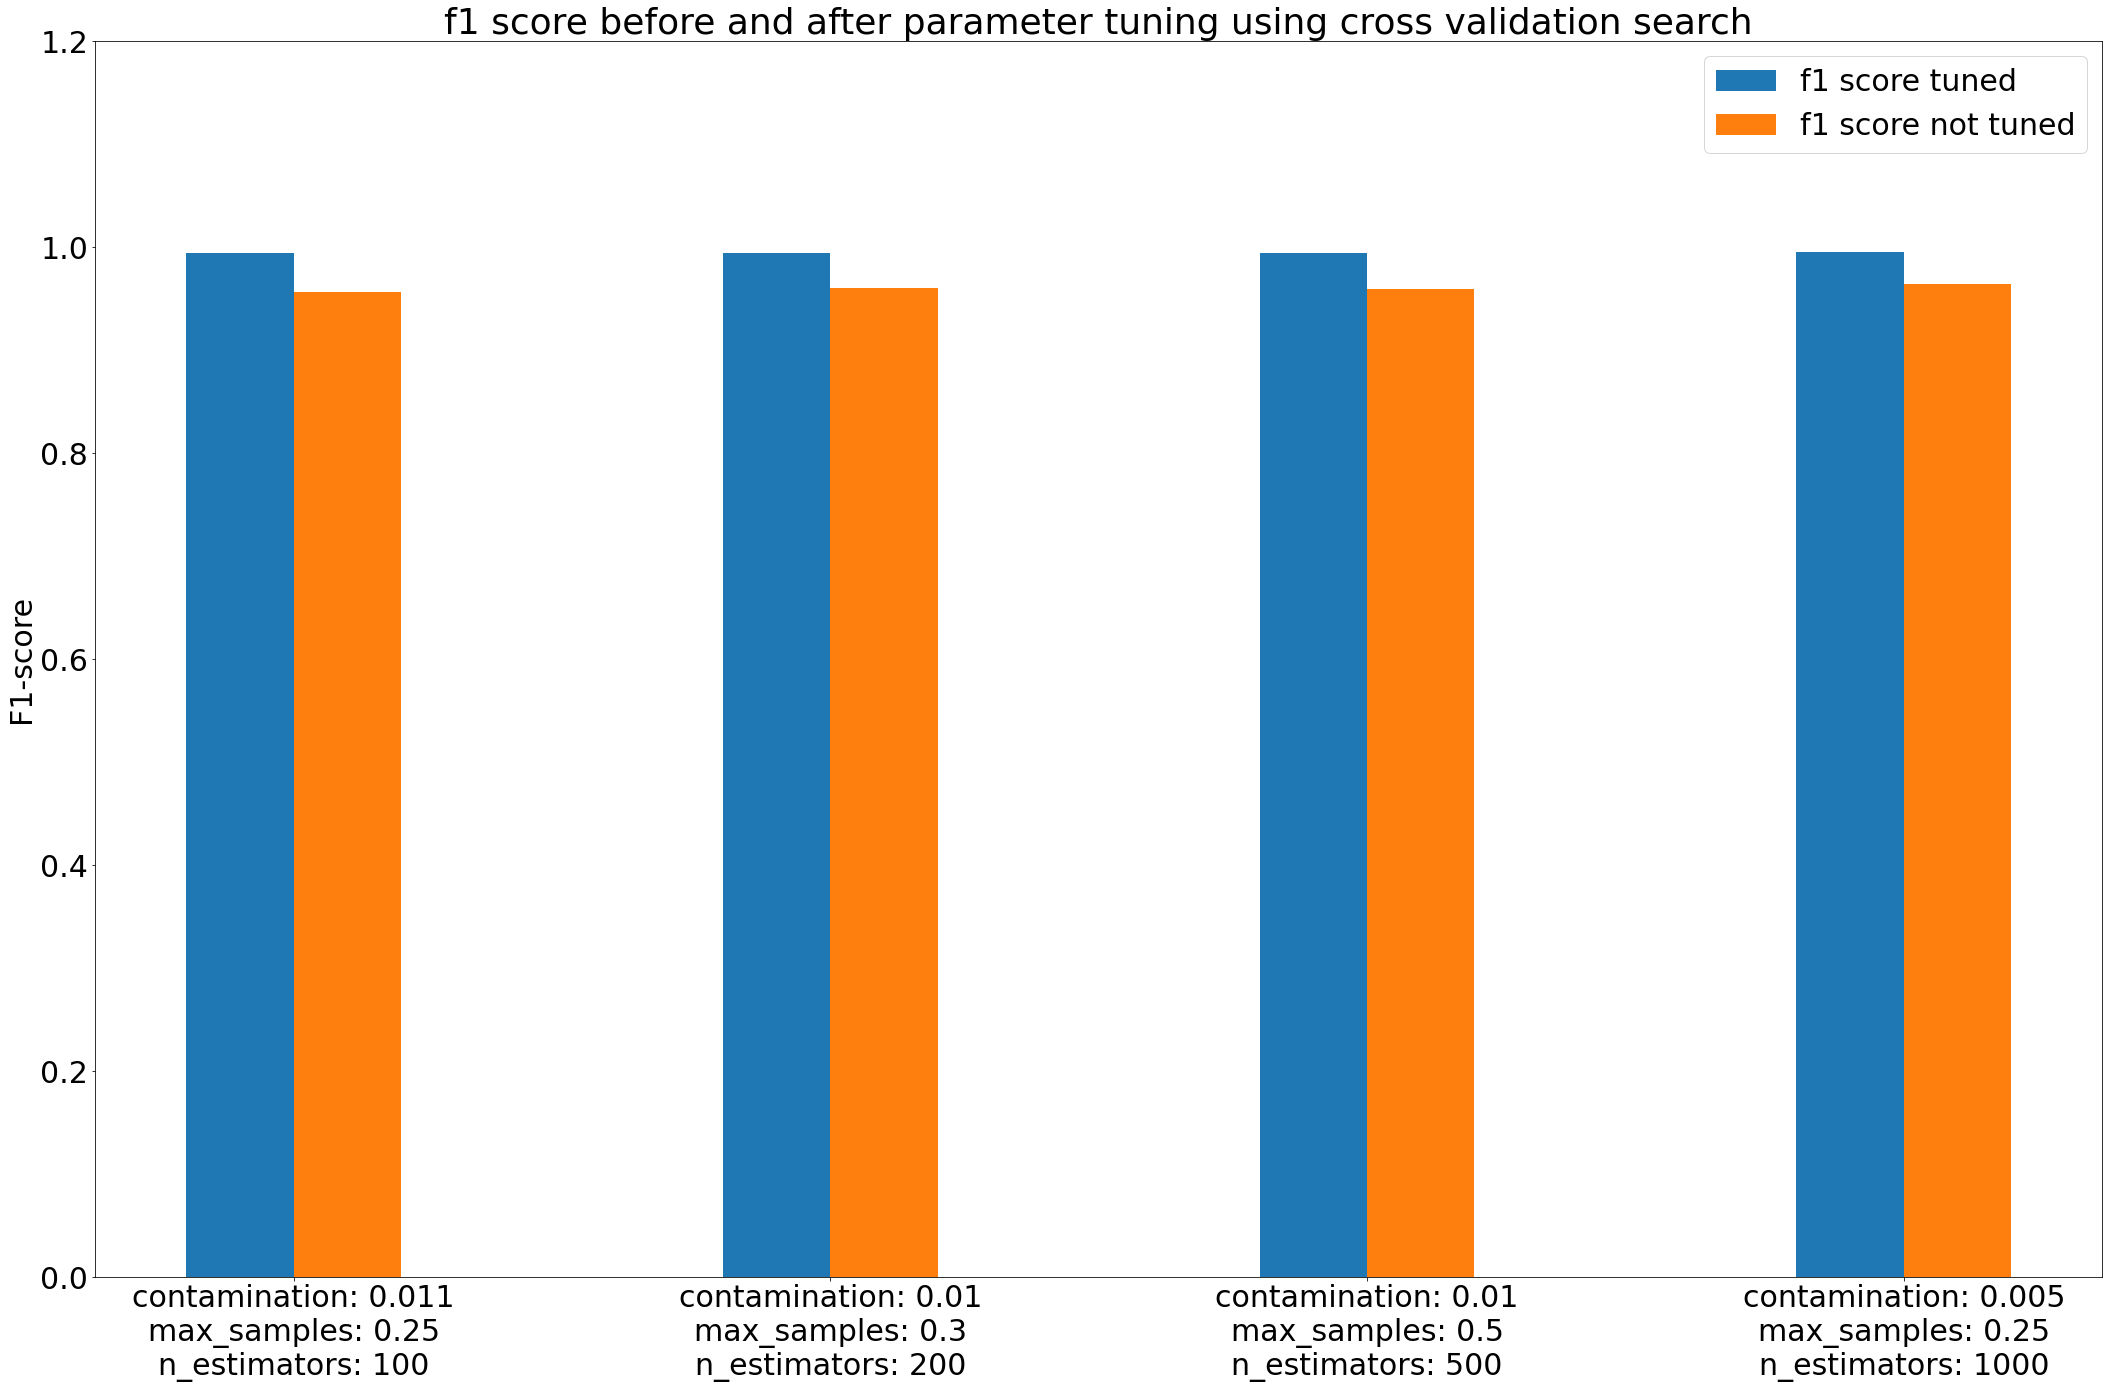

In [143]:
fig, ax = plt.subplots(figsize = (30,20))
plt.rc('font', size=30)
ax.set_ylim(0, 1.2)

f1_tuned = [0.9938100232381187, 0.9942422373020768, 0.9938514652089926, 0.9948938578646892]
f1_default = [0.9562713987832191, 0.9597852245622667, 0.9585052379616803, 0.9640969083271412]
width = 1
labels = [f"contamination: {best_param_1['contamination']}\nmax_samples: {best_param_1['max_samples']}\nn_estimators: {best_param_1['n_estimators']}", 
          f"contamination: {best_param_2['contamination']}\nmax_samples: {best_param_2['max_samples']}\nn_estimators: {best_param_2['n_estimators']}", 
          f"contamination: {best_param_3['contamination']}\nmax_samples: {best_param_3['max_samples']}\nn_estimators: {best_param_3['n_estimators']}", 
          f"contamination: {best_param_4['contamination']}\nmax_samples: {best_param_4['max_samples']}\nn_estimators: {best_param_4['n_estimators']}"]
ax.set_xticks([i*5 + width/2 for i in range(len(f1_tuned))])
ax.set_xticklabels(labels)
ax.set_ylabel('F1-score')
ax.set_title('f1 score before and after parameter tuning using cross validation search')

ax.bar([i*5 for i in range(len(f1_tuned))], f1_tuned, width=width)
ax.bar([i*5 + width for i in range(len(f1_tuned))], f1_default, width=width)
fig.tight_layout()
ax.legend(['f1 score tuned', 'f1 score not tuned'])
plt.show()

# Manual parameter tuning

In [8]:
def cross_validation(contamination, max_samples, n_estimators, random_state, silent=True):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state= random_state, n_jobs=-1, max_samples = max_samples, n_estimators = n_estimators, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        f = f1_score(y_test, y_pred, average = "macro")
        r = recall_score(y_test, y_pred, pos_label = -1)
        a = roc_auc_score(y_test, y_pred)
        if f + r > highest_score: highest_score = f + r; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        
        fp = tp / p - tp
        # predicted true
        positives = yp[np.where(yp == -1)]
        if not silent:
            print(f"Finished trainning in {t} seconds")
            print(f"contamination: {c} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
            print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
            print("--------------------")
    return (highest_score_c, y_pred, f, len(positives) - tp, tp, p, r, t)

In [9]:
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

In [10]:
r = 0.005
rs = 1

target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(r, r * 20, r)
max_samples = 0.25
n_estimators = 100

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
print("Time for IF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
Y_axis_auc.append(roc_auc_score(y_test, y_pred))
best_param.append((rs, cmax, max_samples, n_estimators))
print(rs, cmax, max_samples, n_estimators)

anomaly rate is 0.5% out of 977669 records (4889)
Finished trainning in 0:01:28.228956 seconds
contamination: 0.005 	 tp: 407/support: 1182/predicted: 1248 -> fp = 841
AUC : 67.0% 	 precision: 0.326 	 recall: 0.344 	 f1: 0.6658285482149588
--------------------
Finished trainning in 0:01:28.210243 seconds
contamination: 0.01 	 tp: 566/support: 1182/predicted: 2449 -> fp = 1883
AUC : 73.6% 	 precision: 0.231 	 recall: 0.479 	 f1: 0.6533047227131344
--------------------
Finished trainning in 0:01:28.196498 seconds
contamination: 0.015 	 tp: 1181/support: 1182/predicted: 3634 -> fp = 2453
AUC : 99.5% 	 precision: 0.325 	 recall: 0.999 	 f1: 0.7426892332776123
--------------------
Finished trainning in 0:01:28.245484 seconds
contamination: 0.02 	 tp: 1181/support: 1182/predicted: 4847 -> fp = 3666
AUC : 99.2% 	 precision: 0.244 	 recall: 0.999 	 f1: 0.6920889646360684
--------------------
Finished trainning in 0:01:28.098336 seconds
contamination: 0.025 	 tp: 1181/support: 1182/predicted: 6

In [12]:
r = 0.01
rs = 2

target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(r, r * 20, r)
max_samples = 0.25
n_estimators = 100

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
print("Time for IF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
Y_axis_auc.append(roc_auc_score(y_test, y_pred))
best_param.append((rs, cmax, max_samples, n_estimators))
print(rs, cmax, max_samples, n_estimators)

anomaly rate is 1.0% out of 982607 records (9827)
Finished trainning in 0:01:27.593263 seconds
contamination: 0.01 	 tp: 1102/support: 2521/predicted: 2456 -> fp = 1354
AUC : 71.6% 	 precision: 0.449 	 recall: 0.437 	 f1: 0.7185675627977031
--------------------
Finished trainning in 0:01:27.474104 seconds
contamination: 0.02 	 tp: 1261/support: 2521/predicted: 4698 -> fp = 3437
AUC : 74.3% 	 precision: 0.268 	 recall: 0.5 	 f1: 0.6698265125101821
--------------------
Finished trainning in 0:01:27.699465 seconds
contamination: 0.03 	 tp: 2521/support: 2521/predicted: 7441 -> fp = 4920
AUC : 99.0% 	 precision: 0.339 	 recall: 1.0 	 f1: 0.7479509229070158
--------------------
Finished trainning in 0:01:27.712023 seconds
contamination: 0.04 	 tp: 2521/support: 2521/predicted: 9917 -> fp = 7396
AUC : 98.5% 	 precision: 0.254 	 recall: 1.0 	 f1: 0.6949629083208195
--------------------
Finished trainning in 0:01:27.631716 seconds
contamination: 0.05 	 tp: 2521/support: 2521/predicted: 12358 -

In [14]:
r = 0.05
rs = 3

target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(r, r * 10, r)
max_samples = 0.25
n_estimators = 100

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
print("Time for IF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
Y_axis_auc.append(roc_auc_score(y_test, y_pred))
best_param.append((rs, cmax, max_samples, n_estimators))
print(rs, cmax, max_samples, n_estimators)

anomaly rate is 5.0% out of 1023979 records (51199)
Finished trainning in 0:01:57.549214 seconds
contamination: 0.05 	 tp: 4341/support: 12636/predicted: 12590 -> fp = 8249
AUC : 65.5% 	 precision: 0.345 	 recall: 0.344 	 f1: 0.6550904959073501
--------------------
Finished trainning in 0:01:57.702646 seconds
contamination: 0.1 	 tp: 5561/support: 12636/predicted: 24694 -> fp = 19133
AUC : 68.1% 	 precision: 0.225 	 recall: 0.44 	 f1: 0.6213615286022713
--------------------
Finished trainning in 0:01:57.864708 seconds
contamination: 0.15000000000000002 	 tp: 6378/support: 12636/predicted: 36752 -> fp = 30374
AUC : 69.0% 	 precision: 0.174 	 recall: 0.505 	 f1: 0.5895472517413689
--------------------
Finished trainning in 0:01:57.513586 seconds
contamination: 0.2 	 tp: 12632/support: 12636/predicted: 50519 -> fp = 37887
AUC : 92.2% 	 precision: 0.25 	 recall: 1.0 	 f1: 0.6578054449405654
--------------------
Finished trainning in 0:01:29.425048 seconds
contamination: 0.25 	 tp: 12636/su

In [15]:
r = 0.1
rs = 4

target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(r, r * 5, r)
max_samples = 0.25
n_estimators = 100

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
print("Time for IF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
Y_axis_auc.append(roc_auc_score(y_test, y_pred))
best_param.append((rs, cmax, max_samples, n_estimators))
print(rs, cmax, max_samples, n_estimators)

anomaly rate is 10.0% out of 1080867 records (108087)
Finished trainning in 0:01:37.715450 seconds
contamination: 0.1 	 tp: 9314/support: 27178/predicted: 27181 -> fp = 17867
AUC : 63.5% 	 precision: 0.343 	 recall: 0.343 	 f1: 0.6345877559511223
--------------------
Finished trainning in 0:01:37.979200 seconds
contamination: 0.2 	 tp: 13864/support: 27178/predicted: 54194 -> fp = 40330
AUC : 67.2% 	 precision: 0.256 	 recall: 0.51 	 f1: 0.6119501793741753
--------------------
Finished trainning in 0:01:37.612328 seconds
contamination: 0.30000000000000004 	 tp: 27177/support: 27178/predicted: 81232 -> fp = 54055
AUC : 88.9% 	 precision: 0.335 	 recall: 1.0 	 f1: 0.6881258667924482
--------------------
Finished trainning in 0:01:37.522073 seconds
contamination: 0.4 	 tp: 27178/support: 27178/predicted: 108108 -> fp = 80930
AUC : 83.4% 	 precision: 0.251 	 recall: 1.0 	 f1: 0.6010158411853697
--------------------
Time for IF fitting: 391.968
4 0.30000000000000004 0.25 100


In [18]:
r = 0.5
rs = 5

target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=rs)

contaminations = np.arange(r, r * 2, r/5)
max_samples = 0.25
n_estimators = 100

stime = time.time()
cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
print("Time for IF fitting: %.3f" % (time.time() - stime))
Y_axis_f1.append(f)
Y_axis_recall.append(r)
Y_axis_auc.append(roc_auc_score(y_test, y_pred))
best_param.append((rs, cmax, max_samples, n_estimators))
print(rs, cmax, max_samples, n_estimators)

anomaly rate is 50.0% out of 1945560 records (972780)
Finished trainning in 0:03:16.817983 seconds
contamination: 0.5 	 tp: 107523/support: 243074/predicted: 243415 -> fp = 135892
AUC : 44.2% 	 precision: 0.442 	 recall: 0.442 	 f1: 0.4419231249706488
--------------------
Finished trainning in 0:03:16.375778 seconds
contamination: 0.6 	 tp: 123810/support: 243074/predicted: 292014 -> fp = 168204
AUC : 40.9% 	 precision: 0.424 	 recall: 0.509 	 f1: 0.4029917610491038
--------------------
Finished trainning in 0:03:16.435262 seconds
contamination: 0.7 	 tp: 123810/support: 243074/predicted: 340980 -> fp = 217170
AUC : 30.8% 	 precision: 0.363 	 recall: 0.509 	 f1: 0.2792445674852482
--------------------
Finished trainning in 0:03:16.749297 seconds
contamination: 0.7999999999999999 	 tp: 123810/support: 243074/predicted: 367126 -> fp = 243316
AUC : 25.5% 	 precision: 0.337 	 recall: 0.509 	 f1: 0.2029006882989184
--------------------
Finished trainning in 0:03:17.013808 seconds
contaminat

In [25]:
best_param

[(1, 0.015, 0.25, 100),
 (2, 0.03, 0.25, 100),
 (3, 0.2, 0.25, 100),
 (4, 0.3, 0.25, 100),
 (1, 0.5, 0.25, 100),
 (5, 0.6, 0.25, 100)]

In [27]:
f1_tuned = []
auc_tuned = []
r_tuned = []
f1_not_tuned = []
r_not_tuned = []
auc_not_tuned = []
source_metric = []
best_param = [(0.005, 1, 0.015, 0.25, 100),(0.01, 2, 0.03, 0.25, 100),
 (0.05, 3, 0.2, 0.25, 100),
 (0.1, 4, 0.3, 0.25, 100),
 (0.5, 5, 0.6, 0.25, 100)]


for r, rs, c, ms, ne in best_param:
    print(f"---{[rs, c, ms, ne]}")
    rs = 1

    target_anomaly_rate = r
    n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
    df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
    df_sample = df_sample.sample(frac=1, random_state=1)
    anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
    print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

    df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
    toDecode = ["protocol_type", "service", "flag", "target"]
    leSF = preprocessing.LabelEncoder()
    for f in toDecode:
        df_sample[f] = leSF.fit_transform(df_sample[f])

    x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.25, random_state=rs)


    stime = time.time()
    y_pred = IsolationForest(random_state= rs, n_jobs=-1, max_samples = ms, n_estimators = ne, contamination=c).fit(x_train).predict(x_test)
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    f = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)
    source_metric.append((y_test, y_pred))
    y_pred = IsolationForest(contamination = 0.005, random_state= rs, n_jobs = -1).fit(x_train).predict(x_test)
    f = f1_score(y_test, y_pred, average = 'weighted')
    print(f"---{f}, {fm}")
    fm = f1_score(y_test, y_pred, average = 'macro')
    f1_not_tuned.append(f)
    r_not_tuned.append(recall_score(y_test, y_pred, average = 'macro'))
    auc_not_tuned.append(roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    

---[1, 0.015, 0.25, 100]
anomaly rate is 0.5% out of 977669 records (4889)
Time for IF fitting: 97.612
              precision    recall  f1-score   support

          -1       0.32      1.00      0.49      1182
           1       1.00      0.99      0.99    243236

    accuracy                           0.99    244418
   macro avg       0.66      0.99      0.74    244418
weighted avg       1.00      0.99      0.99    244418

---0.9924903004925064, 0.7426892332776123
---0.9945345602255923
---0.9945345602255922
---0.9929518228014276, 0.7426892332776123
              precision    recall  f1-score   support

          -1       0.27      0.28      0.27      1182
           1       1.00      1.00      1.00    243236

    accuracy                           0.99    244418
   macro avg       0.63      0.64      0.64    244418
weighted avg       0.99      0.99      0.99    244418

---[2, 0.03, 0.25, 100]
anomaly rate is 1.0% out of 982607 records (9827)
Time for IF fitting: 92.882
             

In [30]:
best_param

[(0.005, 1, 0.015, 0.25, 100),
 (0.01, 2, 0.03, 0.25, 100),
 (0.05, 3, 0.2, 0.25, 100),
 (0.1, 4, 0.3, 0.25, 100),
 (0.5, 5, 0.6, 0.25, 100)]

In [31]:
Y_axis_auc

[0.9548812675755234,
 0.9095772887779893,
 0.9087528945301093,
 0.5308001758718601,
 0.7903036255079944,
 0.8335040878212961,
 0.4409523881019147,
 0.44192335875890526,
 0.2546755309082831]

<ipython-input-34-51a4f8d99cc7>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


[(0.005, 1, 0.015, 0.25, 100), (0.01, 2, 0.03, 0.25, 100), (0.05, 3, 0.2, 0.25, 100), (0.1, 4, 0.3, 0.25, 100), (0.5, 5, 0.6, 0.25, 100)]


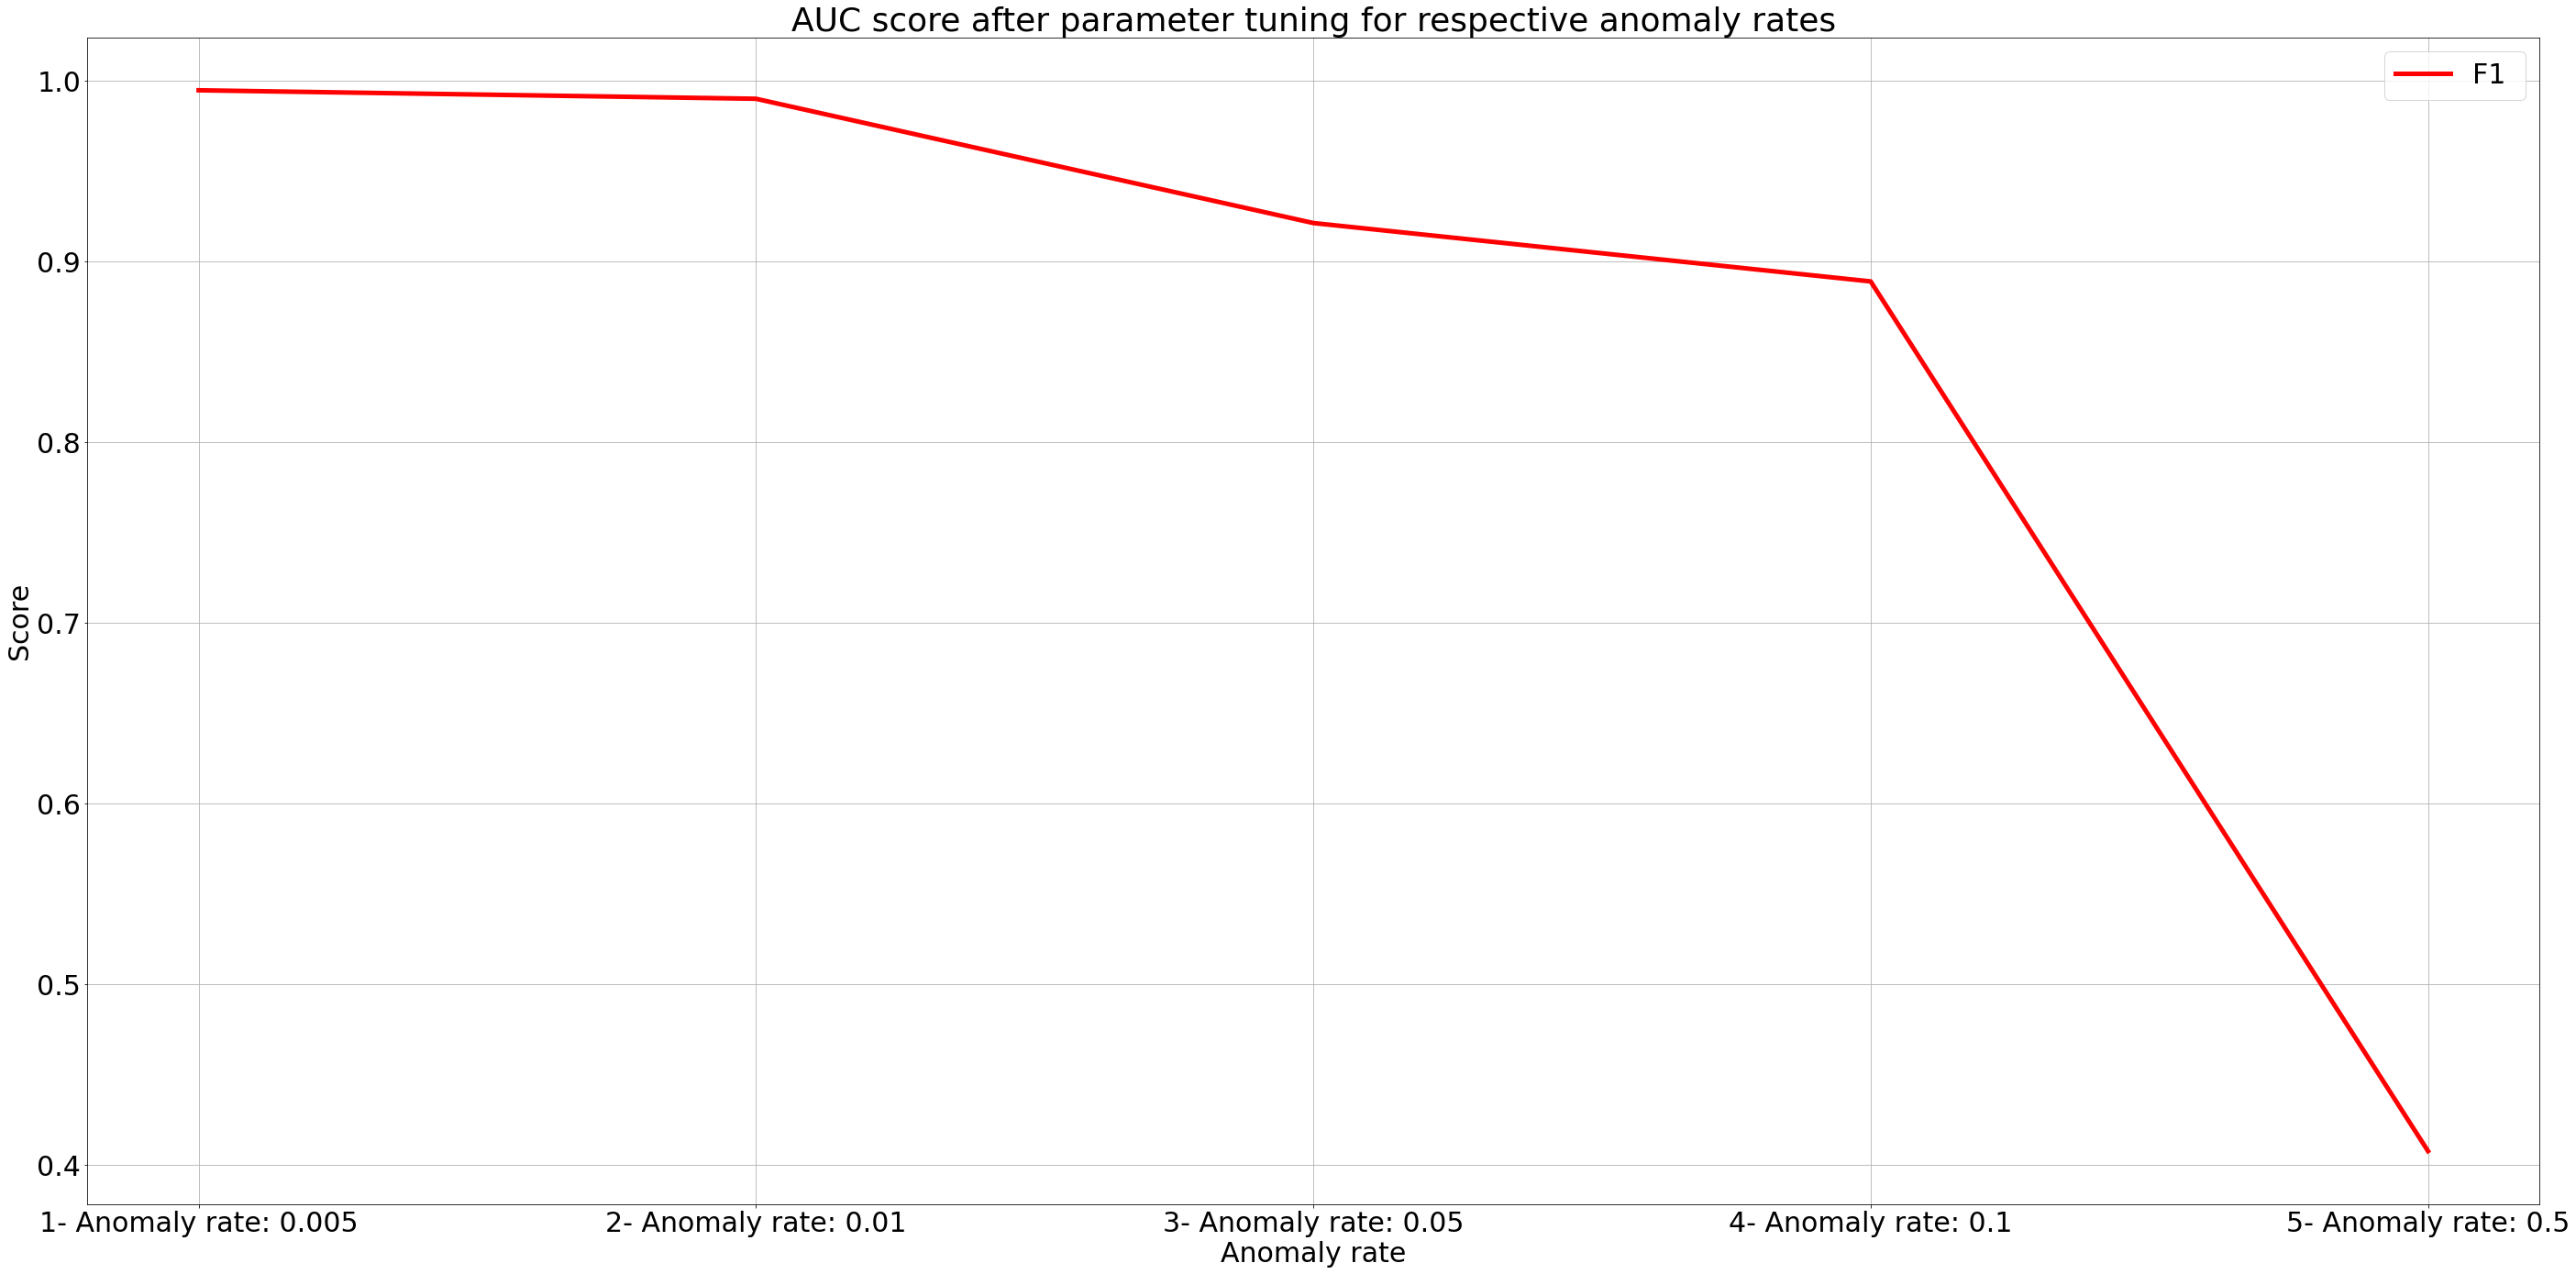

In [34]:
# f1_tuned = [0.9954178136425095, 0.9952542140292294, 0.9953171367636211, 0.9952334249285871]

plt.figure(figsize=(40,20))
plt.rc('font', size=30)
plt.title('AUC score after parameter tuning for respective anomaly rates')
plt.xlabel("Anomaly rate")
plt.ylabel("Score")
ax = plt.axes()
# ax.set_ylim(0.994, 0.996)
pad = 0.005

print(best_param)

# labels = [f"{i}-{p}" for i,p in enumerate(best_param)]
labels = [f"{rs}- Anomaly rate: {r}" for r, rs, c, ms, n in best_param]
colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'AUC'


# Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)

ax.plot(X_axis, auc_tuned, '-', color=colors['1'],label="%s " % ("F1"), linewidth=5)
# ax.plot(X_axis, Y_axis_recall, '-', color=colors['2'],label="%s " % ("Recall"), linewidth=5)
plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("IF_graph_AR_v2.png", dpi=100)

plt.show()